# 0. Install and Import Dependencies

In [1]:
!pip list

Package                   Version
------------------------- --------------
absl-py                   2.1.0
altair                    5.4.1
anyio                     4.5.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asgiref                   3.7.2
asttokens                 2.4.1
astunparse                1.6.3
async-lru                 2.0.4
attrs                     24.2.0
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.1.0
blinker                   1.9.0
cachetools                5.5.0
certifi                   2024.7.4
cffi                      1.16.0
charset-normalizer        3.3.2
click                     8.1.7
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.0
cycler                    0.12.1
debugpy                   1.8.5
decorator                 5.1.1
defusedxml                0.7.1
Django                    5.0.3
docutils           

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [7]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num(['n','i','c','k'])

In [11]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [12]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [25]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [26]:
test_path = '.\\data\\s1\\video.mpg'

In [27]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'video'

In [29]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [39]:
print(f"Number of frames: {len(frames)}")


Number of frames: 0


Number of frames loaded: 60


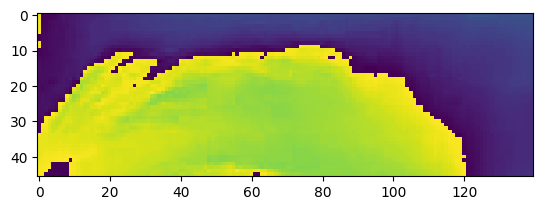

In [41]:
frames = load_video('.\\data\\s1\\video.mpg')
print(f"Number of frames loaded: {len(frames)}")

if len(frames) > 40:
    plt.imshow(frames[40])
else:
    print(f"Video has only {len(frames)} frames. Cannot access frame 40.")


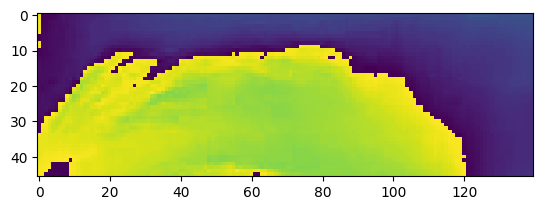

In [42]:
plt.imshow(frames[40])

In [43]:
alignments

<tf.Tensor: shape=(38,), dtype=int64, numpy=
array([ 8,  5, 12, 12, 15, 39,  5, 22,  5, 18, 25, 15, 14,  5, 39, 13, 25,
       39, 14,  1, 13,  5,  9, 19, 39, 20,  1, 18, 21, 14,  1, 39, 13,  1,
       21, 18, 25,  1], dtype=int64)>

In [44]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'hello everyone my nameis taruna maurya'>

In [45]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [46]:
from matplotlib import pyplot as plt

In [47]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [48]:
len(test)

51

In [49]:
frames, alignments = data.as_numpy_iterator().next()

In [50]:
len(frames)

2

In [51]:
sample = data.as_numpy_iterator()

In [52]:
val = sample.next(); val[0]

array([[[[[1.3058484 ],
          [1.3058484 ],
          [1.3804682 ],
          ...,
          [0.783509  ],
          [0.82081896],
          [0.14923981]],

         [[1.3058484 ],
          [1.3058484 ],
          [1.3804682 ],
          ...,
          [0.5596493 ],
          [0.82081896],
          [9.290178  ]],

         [[1.2685384 ],
          [1.2685384 ],
          [1.2685384 ],
          ...,
          [0.03730995],
          [0.22385971],
          [9.327488  ]],

         ...,

         [[0.9327488 ],
          [0.9327488 ],
          [0.89543885],
          ...,
          [0.03730995],
          [0.        ],
          [0.        ]],

         [[0.9327488 ],
          [0.9327488 ],
          [0.89543885],
          ...,
          [0.        ],
          [9.514038  ],
          [9.514038  ]],

         [[0.9327488 ],
          [0.9327488 ],
          [0.89543885],
          ...,
          [0.        ],
          [9.514038  ],
          [9.514038  ]]],


        [[[1.3431

In [61]:
import imageio
import numpy as np

# Assuming val[0][0] contains the frames with shape (75, 46, 140, 1)
frames = val[0][0]

# Check the shape of the frames
print(f"Shape of frames: {frames.shape}")

# Convert frames to (num_frames, height, width, 3) if grayscale (i.e., having only 1 channel)
if frames.shape[-1] == 1:
    # Convert to 3-channel RGB by repeating the grayscale values
    frames = np.repeat(frames, 3, axis=-1)

# Ensure the frames are in uint8 format and scale to [0, 255] if needed
frames = np.uint8(frames * 255)  # if frames are normalized between [0, 1], otherwise just cast

# Now save the frames as an animated GIF
imageio.mimsave('./animation.gif', frames, fps=10)


# imageio.mimsave('./animation.gif', val[0][0], fps=10)

Shape of frames: (75, 46, 140, 1)


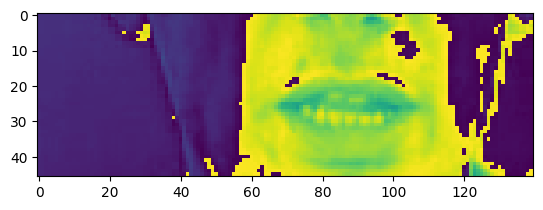

In [62]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [63]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l eight please'>

# 3. Design the Deep Neural Network

In [64]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [65]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [66]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

c:\Users\TARUNA MAURYA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
5*17*75

6375

In [69]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [70]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'ttttttttttttttttttttfffffffftfffffffffffffffttttttttttttttttjjjjjjjjjjccccc'>

In [71]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ttttttttttttttttttttfffffffftfffffffffffffffttttttttttttttttjjjjjjjjjjccccc'>

In [72]:
model.input_shape

(None, 75, 46, 140, 1)

In [73]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [74]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [75]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [77]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [78]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [80]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

# checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [81]:
schedule_callback = LearningRateScheduler(scheduler)

In [82]:
example_callback = ProduceExample(test)

In [84]:
import tensorflow as tf

# Define CTC loss using the Keras API
def ctc_loss(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.ctc_batch_cost(y_true, y_pred))

# Example model compilation
model.compile(optimizer='adam', loss=ctc_loss)


In [86]:
import tensorflow as tf

# Define CTC loss using the Keras API
def ctc_loss(y_true, y_pred):
    # Calculate input_length and label_length
    input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])  # Assuming input length is equal for all sequences
    label_length = tf.fill([tf.shape(y_true)[0]], tf.shape(y_true)[1])  # Assuming label length is equal for all sequences

    return tf.reduce_mean(tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length))

# Example model compilation
model.compile(optimizer='adam', loss=ctc_loss)


In [88]:
import tensorflow as tf

# Define CTC loss using the Keras API
def ctc_loss(y_true, y_pred):
    # Calculate input_length as the time dimension of y_pred (number of time steps)
    input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])  # Time steps (y_pred.shape[1])
    
    # Calculate label_length as the number of non-padding elements in y_true (max_label_length)
    label_length = tf.fill([tf.shape(y_true)[0]], tf.shape(y_true)[1])  # Label length (y_true.shape[1])

    return tf.reduce_mean(tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length))

# Example model compilation
model.compile(optimizer='adam', loss=ctc_loss)


In [91]:
def ctc_loss(y_true, y_pred):
    print(f"y_true shape: {y_true.shape}")
    print(f"y_pred shape: {y_pred.shape}")
    
    input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])  # Time steps (y_pred.shape[1])
    label_length = tf.fill([tf.shape(y_true)[0]], tf.shape(y_true)[1])  # Label length (y_true.shape[1])

    return tf.reduce_mean(tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length))


In [92]:
import tensorflow as tf

# Define CTC loss function
def ctc_loss(y_true, y_pred):
    # Ensure y_true is integer encoded (not one-hot encoded)
    # y_pred: (batch_size, time_steps, num_classes)
    # y_true: (batch_size, max_label_length)
    
    # Calculate the input length (time steps) for each sample
    input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])  # All sequences have the same length
    
    # Calculate label length (this is the actual length of each label in the batch)
    label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.int32), axis=1)  # Assuming 0 is padding in y_true
    
    # Use Keras CTC loss function
    return tf.reduce_mean(tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length))

# Example of how to compile your model with the custom loss
model.compile(optimizer='adam', loss=ctc_loss)


In [97]:
def ctc_loss(y_true, y_pred):
    print(f"y_true shape: {y_true.shape}")
    print(f"y_pred shape: {y_pred.shape}")

    # Calculate the input length (time steps for each sequence)
    input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])  # All sequences have the same length

    # Calculate the label length (the number of non-padding labels)
    label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.int32), axis=1)

    return tf.reduce_mean(tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length))


In [99]:
y_true = [[1, 2, 3, 0],  # Sample 1 (padded with 0)
          [4, 5, 6, 0]]  # Sample 2 (padded with 0)

label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.int32), axis=1)


In [ ]:
import tensorflow as tf

def ctc_loss(y_true, y_pred):
    # Print the shapes of y_true and y_pred for debugging
    print(f"y_true shape: {y_true.shape}")
    print(f"y_pred shape: {y_pred.shape}")
    
    # Adjust input length to match the time steps in y_pred
    input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])  # Set the input length to the number of time steps
    
    # Adjust label length to match the sequence length in y_true
    label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.int32), axis=1)
    
    # Use the built-in CTC loss function
    return tf.reduce_mean(tf.compat.v1.nn.ctc_loss(y_true, y_pred, input_length, label_length))

# Compile your model with the custom CTC loss function
model.compile(optimizer='adam', loss=ctc_loss) 
 



In [108]:
import tensorflow as tf

def ctc_loss(y_true, y_pred):
    # Print the shapes of y_true and y_pred for debugging
    print(f"y_true shape: {y_true.shape}")
    print(f"y_pred shape: {y_pred.shape}")
    
    # Convert y_true (dense) to SparseTensor
    y_true_sparse = tf.sparse.from_dense(tf.cast(y_true, tf.int32))
    
    # Adjust input length to match the time steps in y_pred
    input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])  # Set the input length to the number of time steps
    
    # Adjust label length to match the sequence length in y_true
    label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.int32), axis=1)
    
    # Use the built-in CTC loss function
    return tf.reduce_mean(tf.compat.v1.nn.ctc_loss(y_true_sparse, y_pred, input_length, label_length))

# Compile your model with the custom CTC loss function
model.compile(optimizer='adam', loss=ctc_loss)




In [109]:
model.fit(train, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
y_true shape: (None, 40)
y_pred shape: (None, 75, 41)


TypeError: Expected bool for argument 'preprocess_collapse_repeated' not <tf.Tensor 'compile_loss/ctc_loss/Sum:0' shape=(None,) dtype=int32>.

# 5. Make a Prediction 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [53]:
model.load_weights('models/checkpoint')

In [54]:
test_data = test.as_numpy_iterator()

In [56]:
sample = test_data.next()

In [57]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 973ms/step


In [58]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

In [59]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [60]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

# Test on a Video

In [61]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [62]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [63]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 720ms/step


In [64]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [65]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]